# VAE 圖片生成過程
[NCTS]作業11-1
使用VAE來做手寫辨識，將最後的結果動態呈現出來，打造最好的呈現方式!
想想在encoder找到兩張手寫數字 a, b 的 latent representation，然後從代表 a 的 latent 到代表 b 的 latent 拉一直線, 把線段中代表的圖用 decoder 畫出來，這個必須是動態的圖片變化，可參考上禮拜上課呈現出來中間那張圖的樣子

*模型權重可使用澤佑助教提供的

## 1. 初始準備

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider
from ipywidgets import interact_manual

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 2. 讀入 MNIST 並整理資料格式

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [5]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

## 3. 建立 VAE
函數 :

In [6]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

變數 :

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

Instructions for updating:
Colocations handled automatically by placer.


定義抽樣函數 :

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [11]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

 建立 Loss 函數 :

In [12]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [13]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [14]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

## 4. VAE 視覺化呈現

In [15]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [16]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [17]:
def choose_number(number):
    data_num = []
    for i in range (len(y_train0)):
        if y_train0[i] == number:
            data_num.append(i)
    idx = np.random.choice(data_num, 1)
    return idx 

In [43]:
def test(Num1, Num2, t):
    idx_1 = choose_number(Num1)
    idx_2 = choose_number(Num2)
    inBetween(idx_1, idx_2, t)

In [44]:
def inBetween(idx_1, idx_2, t):
    
    data_0 = x_train0[idx_1[0]]
    data_1 = x_train0[idx_2[0]]
    data_t = (1-t)*x_train0[idx_1[0]] + t*x_train0[idx_2[0]]

    mu_0 = VAE_Encoder.predict(x_train[idx_1[0]:idx_1[0]+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2[0]:idx_2[0]+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('Num1')
    ax2.set_axis_off()
    
    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title('t = ' + str(t))
    ax3.set_axis_off()

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('Num2')
    ax4.set_axis_off()

In [45]:
interact(test, Num1 = num_choice, Num2 = num_choice, t=FloatSlider(value=0.5, min=0, max=1.0, step=0.02,))

interactive(children=(Dropdown(description='Num1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(description='Num2', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('widget-interact',))

<function __main__.test>

In [19]:
num_choice = range(10)

In [20]:
interact_manual(inBetween, Num1 = num_choice, Num2 = num_choice, t=FloatSlider(value=0.5, min=0, max=1.0, step=0.02,))

interactive(children=(Dropdown(description='Num1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(description='Num2', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.inBetween>

# 測試

In [36]:
def data_test(Num1, Num2):
    idx_1 = choose_number(Num1)
    idx_2 = choose_number(Num2)
    

In [37]:
def inBetween(t):
    idx1, idx2 = data_test(Num1, Num2)
    
    data_0 = x_train0[idx_1[0]]
    data_1 = x_train0[idx_2[0]]
    data_t = (1-t)*x_train0[idx_1[0]] + t*x_train0[idx_2[0]]

    mu_0 = VAE_Encoder.predict(x_train[idx_1[0]:idx_1[0]+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2[0]:idx_2[0]+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')
    ax2.set_title('Num1')
    ax2.set_axis_off()
    
    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')
    ax3.set_title('t = ' + str(t))
    ax3.set_axis_off()

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')
    ax4.set_title('Num2')
    ax4.set_axis_off()

In [30]:
a,b=data_test(1,2)

In [33]:
a

array([10562])

In [38]:
interact(inBetween, t=FloatSlider(value=0.5, min=0, max=1.0, step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('widget-interact',))

<function __main__.inBetween>

In [35]:
interact(data_test, Num1 = num_choice, Num2 = num_choice)
interact_manual(inBetween, t=FloatSlider(value=0.5, min=0, max=1.0, step=0.02,))

interactive(children=(Dropdown(description='Num1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(description='Num2', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.inBetween>

In [21]:
x_test.shape[0]

10000

In [22]:
def test1(Num1, Num2):
    idx_1 = choose_number(Num1)
    idx_2 = choose_number(Num2)
    interact(t=FloatSlider(value=0.5, min=0, max=1.0, step=0.02,))

In [23]:
def test2(t):
    idx_1 = choose_number(Num1)
    idx_2 = choose_number(Num2)
    data_0 = x_train0[idx_1[0]]
    data_1 = x_train0[idx_2[0]]
    data_t = (1-t)*x_train0[idx_1[0]] + t*x_train0[idx_2[0]]

    mu_0 = VAE_Encoder.predict(x_train[idx_1[0]:idx_1[0]+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2[0]:idx_2[0]+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='Greys')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='Greys')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='Greys')

In [24]:
interact_manual(test1, Num1 = num_choice, Num2 = num_choice)

interactive(children=(Dropdown(description='Num1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown(description='Num2', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.test1>

In [25]:
idx_1 = choose_number(5)
idx_2 = choose_number(4)
t = 0.5

In [26]:
data_0 = x_train0[idx_1[0]]
data_1 = x_train0[idx_2[0]]
data_t = (1-t)*x_train0[idx_1[0]] + t*x_train0[idx_2[0]]

In [27]:
idx_1[0]

6180

In [28]:
y_test0[idx_1[0]]

2

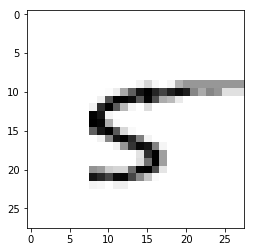

In [29]:
plt.imshow(data_0, cmap = 'Greys')

In [95]:
#進行數據分析之前常要引用的函式庫
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#開發互動功能要引用的函式庫
from ipywidgets import interact

#example1:
#定義好基本的function之後
def f(x):
    print(x**2)
	
#執行interact就有互動功能了	
interact(f, x=2)	

#interact的初始value帶入2.的話，就會讓互動介面的最小單位變成浮點數
interact(f, x=2.)

#也可以限定interact的範圍
interact(f, x=(1.,10.))

#example2
#不同的參數，將會產生不同的interact互動介面
#這個例子的參數是字串
def ShowX(x):
    print("您輸入了{}".format(x))

#初始值帶入"hi"
interact(ShowX,x="hi")

#example3
def f(x):
    print(x)

#會產生下拉式選單(參數帶入list)，並印出taipei, taichung, tainan
interact(f, x=["taipei","taichung","tainan"])

#會產生下拉式選單(參數帶入dictionary)，並印出1, 2, 3
interact(f, x={"taipei":1,"taichung":2,"tainan":3})

#example4
x = np.linspace(0, 2*np.pi, 1000)

def draw(n):
    y = np.sin(n*x)
    #設定線的粗細 = 5
    plt.plot(x, y, lw=5)
    #在jupyter notebook裡面可不加，但是在其他的開發
    #介面，就要加，不然圖形會出現異常
    plt.show()

interact(draw,n=(1., 50.))

#example5
#進行數據分析之前常要引用的函式庫
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#開發互動功能要引用的函式庫
#這裡改成import interact_manual
#每次都要手動按下執行按鈕，才會產生interact畫面
from ipywidgets import interact_manual
#定義一個簡單的function做範例
def f(x):
    print(x * 2)
#互動的結果將會在按下執行按鈕之後才會顯現
interact_manual(f, x=(1., 100.))

interactive(children=(IntSlider(value=2, description='x', max=6, min=-2), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=2.0, description='x', max=6.0, min=-2.0), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=5.5, description='x', max=10.0, min=1.0), Output()), _dom_classes=('widget-interact',))

interactive(children=(Text(value='hi', description='x'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='x', options=('taipei', 'taichung', 'tainan'), value='taipei'), Output()), _dom_classes=('widget-interact',))

interactive(children=(Dropdown(description='x', options={'taipei': 1, 'taichung': 2, 'tainan': 3}, value=1), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=25.5, description='n', max=50.0, min=1.0), Output()), _dom_classes=('widget-interact',))

interactive(children=(FloatSlider(value=50.5, description='x', min=1.0), Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widget-interact',))

<function __main__.f>